# LUNA Basic Tutorial #1 - Calculating and filtering interactions

This tutorial covers: 
* Working with different Entry types (Mol, Ligand, etc)
* Using different filtering options to compute PPI, PLI, PNI, intra- or inter-molecular interactions
* Interaction granularity (proximal, covalent, non-covalent interactions)
* Applying filters on atomic groups or interactions using our built-in functions
* Creating a Pymol session to visualize interactions
* Plotting a Pymol session to depict hydrophobic contacts

### Set up system paths and import LUNA

In [1]:
LUNApath = '/srv/home/lshub/LUNA' #change this to point to LUNA directory

import sys
sys.path.append(LUNApath)

import luna

RDKit WARNING: [13:11:05] Enabling RDKit 2019.09.3 jupyter extensions
/srv/home/lshub/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


**<ins>NOTE:</ins> in luna/util/default_values.py, change the OPENBABEL default location from 
    "/usr/bin/obabel" to location of obabel executable**

## Entries

Entries determine what interactions will be calculated. They can be ligands, chains, etc, and can be defined in a number of ways. Each entry has an associated protein id, used to calculate the interface interactions.

In [2]:
from luna.mol.entry import Entry, MolEntry, ChainEntry

### From mol file 

In [3]:
#single mol file
entry = MolEntry.from_mol_file("D4", "ZINC000007786517", "./inputs/ZINC000007786517.mol", 
                                    mol_obj_type='rdkit', is_multimol_file=False)
#multimol file
entries = MolEntry.from_mol_file("D4", "ZINC000007786517", "./inputs/all_ligands.mol", 
                                    mol_obj_type='rdkit', is_multimol_file=True)

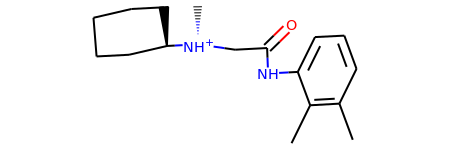

In [4]:
entry.mol_obj
#entries.mol_obj

### From PDB file

#### Download from PDB

If the file does not exist locally, download from PDB by pdb_id

In [5]:
pdb_id = '3QQK'
input_path = "./inputs"
output_path = "./outputs"
luna.MyBio.util.download_pdb(pdb_id = pdb_id, output_path = input_path)

In [6]:
!ls ./inputs #confirm download

3QQK.pdb	 ZINC000007786517.mol  ZINC000357551804.mol
all_ligands.mol  ZINC000113177982.mol  ZINC000661525536.mol
D4.pdb		 ZINC000348555593.mol


#### Parse PDB file

In [7]:
pdb_file = '%s/%s.pdb' % (input_path, pdb_id)

# BioPython part: parse a pdb file into a structure object.
PDB_PARSER = luna.MyBio.PDB.PDBParser(PERMISSIVE = True, QUIET = True, FIX_ATOM_NAME_CONFLICT = False, 
                                      FIX_OBABEL_FLAGS = False)
structure = PDB_PARSER.get_structure(pdb_id, pdb_file)

# The function recover_entries_from_entity() allows you to recover all chains and ligands from a PDB file 
# and return a list of strings. Setting get_chains = False recovers ligands only.
for entity_entry in luna.mol.entry.recover_entries_from_entity(structure, get_chains = False):
    print(entity_entry)

3QQK:A:EDO:490
3QQK:A:EDO:491
3QQK:A:EDO:492
3QQK:A:EDO:493
3QQK:A:EDO:496
3QQK:A:X02:497


#### Define entry manually

In [8]:
# ligand entry - X02
X02_entry = Entry("3QQK", "A", "X02", 497)
# or...
X02_entry = Entry.from_string("3QQK:A:X02:497", sep=":")

## Job setup

### Setting up parameters

In [9]:
opt = {}

opt['entries'] = [entry] #The list of entries to calculate 
opt['working_path'] = output_path # Where project results will be saved
opt['pdb_path'] = input_path # Path contiaining input PDB file - name must match that of entry pdb string.

opt['overwrite_path'] = False # Allows script to overwrite directoary - can remove files from previous project

opt['try_h_addition'] = False  # Define if you need to add Hydrogens or not
opt['ph'] = 7.4 # Controls the pH and how the hydrogens are going to be added - default 7.4
opt['amend_mol'] = False

opt['mol_obj_type'] = 'rdkit' # What type of mol object, options are 'rdkit' and 'openbabel' - default rdkit
opt['calc_ifp'] = False # Whether or not to calculate interaction fingerprint

opt['nproc'] = None #run serially

opt['logging_enabled'] = True # Enable logger
opt['verbosity'] = 2 # How verbose is the logger

## Specifying what interactions to consider

### Interaction Configuration
This is the set of rules that define the distances and angles used to define the different types of interactions. The default configuration can be found in luna/mol/interaction/calc.py. This can be modified to support different interaction definitions.

In [10]:
from luna.mol.interaction.conf import DefaultInteractionConf

In [11]:
inter_conf = DefaultInteractionConf()
print(inter_conf.conf["max_da_dist_hb_inter"])

3.9


In [12]:
inter_conf.conf["max_da_dist_hb_inter"] = 4.0
print(inter_conf.conf["max_da_dist_hb_inter"])

4.0


In [13]:
opt['inter_conf'] = inter_conf

### Interaction Filters
InteractionFilters can be used to define what interactions to include in the result. Each filter has a specific set of default parameters. Modifying these filter parameters further specifies which of those interactions to include, ex. "ignore_self_inter" to ignore intra-molecular interactions.

In [14]:
from luna.mol.interaction.filter import InteractionFilter

In [15]:
pli_filter = InteractionFilter.new_pli_filter(ignore_self_inter = False) # protein-ligand interactions, including intra-molecular interactions
ppi_filter = InteractionFilter.new_ppi_filter() # protein-protein interactions
pni_filter = InteractionFilter.new_pni_filter() # protein-nucleotide interactions

### Interaction Calculator
Create an interaction calculator with the desired filter and add that to the project options. Like filters, calculators have parameters to control interaction granularity. These include add_non_cov, add_cov, and add_proximal. 

In [16]:
from luna.mol.interaction.calc import InteractionCalculator

In [17]:
inter_calc = InteractionCalculator(inter_filter=pli_filter, add_proximal = False)
opt['inter_calc'] = inter_calc

## Run project
This produces a chunks directory, logs directory, and a results directory

In [18]:
proj_obj = luna.projects.LocalProject(**opt)
proj_obj.run()

[2021-06-08 13:11:08]    INFO            projects.py:308        LUNA version: 0.9.0.
[2021-06-08 13:11:08]    INFO            projects.py:308        Verbosity set to: 2 (WARNING).
[2021-06-08 13:11:08]    WARNING         projects.py:308        The number of processes was set to 'None'. Therefore, LUNA will run jobs sequentially.
[2021-06-08 13:11:08]    INFO            projects.py:308        Preparing project directory './outputs'.
[2021-06-08 13:11:08]    INFO                file.py:102        The directory './outputs/results' already exists, but it will not be cleared.
[2021-06-08 13:11:08]    INFO            projects.py:308        Project directory './outputs' created successfully.
[2021-06-08 13:11:08]    PROGRESS                               0% [                                                  ] 0/1 [Avg: 0.00s/task; Errors: 0] - Entries processing.

/srv/home/lshub/LUNA/luna/projects.py:270: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2021-06-08 13:11:28]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 1/1 [Avg: 19.91s/task; Errors: 0] - Entries processing.


In [19]:
!ls ./outputs

chunks	logs  project_v0.9.0.pkl.gz  results


### Evaluate results

The results for each individual entry can be accessed through the corresponding EntryResult

In [20]:
from luna.analysis.summary import count_interaction_types

In [21]:
entry_result = proj_obj.get_entry_results(entry)

In [22]:
print(f"Total number of interactions: {entry_result.interactions_mngr.size}")

Total number of interactions: 46


In [23]:
count_interaction_types(entry_result.interactions_mngr)

defaultdict(int,
            {'Single bond': 14,
             'Hydrophobic': 7,
             'Aromatic bond': 6,
             'Face-to-slope pi-stacking': 1,
             'Van der Waals': 8,
             'Cation-pi': 2,
             'Van der Waals clash': 1,
             'Face-to-edge pi-stacking': 1,
             'Cation-nucleophile': 1,
             'Hydrogen bond': 3,
             'Ionic': 1,
             'Double bond': 1})

#### Filter interactions by type

In [24]:
list(entry_result.interactions_mngr.filter_by_types(['Hydrogen bond']))

[<InteractionType: compounds=(<AtomGroup: [<ExtendedAtom: D4/0/z/LIG-9999/N2>]>, <AtomGroup: [<ExtendedAtom: D4/0/A/ASP-115/OD2>]>) type=Hydrogen bond>,
 <InteractionType: compounds=(<AtomGroup: [<ExtendedAtom: D4/0/A/HIS-414/NE2>]>, <AtomGroup: [<ExtendedAtom: D4/0/z/LIG-9999/O1>]>) type=Hydrogen bond>,
 <InteractionType: compounds=(<AtomGroup: [<ExtendedAtom: D4/0/z/LIG-9999/N1>]>, <AtomGroup: [<ExtendedAtom: D4/0/A/ASP-115/OD2>]>) type=Hydrogen bond>]

### Visualizing interactions in pymol

In [25]:
from luna.mol.interaction.view import InteractionViewer

In [26]:
entry.pdb_file = './inputs/D4.pdb' # set entry PDB file

all_tuples = [(entry, entry_result.interactions_mngr)]
pse_file = "./outputs/D4-visualization-all.pse"

inter_view = InteractionViewer()
inter_view.new_session(all_tuples, pse_file)

 PyMOL not running, entering library mode (experimental)
 Applying pse_export_version=1.800 compatibility


### Visualizing specific types of interactions

In [27]:
hphobe_inter = list(entry_result.interactions_mngr.filter_by_types(['Hydrophobic']))

hp_tuples = [(entry, hphobe_inter)]
pse_file = "./outputs/D4-visualization-hydrophobic.pse"

inter_view = InteractionViewer()
inter_view.new_session(hp_tuples, pse_file)

 Applying pse_export_version=1.800 compatibility


## Save full project or individual entry result

In [28]:
proj_obj.save(output_file = "./outputs/D4_proj")
entry_result.save(output_file = "./outputs/ZINC000007786517_entry")